In [11]:
import numpy as np
import tensorflow as tf
import string
import pandas as pd
from gensim.models import KeyedVectors
import spacy
import model_utils
import constants
import os
import matplotlib.pyplot as plt
import gensim

In [2]:
df = pd.read_json('../../data/translated/sarcasm/sarcasm_headlines_dataset_pl.json')

In [3]:
df = df.drop(columns=['article_link', 'headline'])
df

,is_sarcastic,headline_pl
0,1,Naukowcy z lat trzydziestych odkrywają zegar z...
1,0,"Reprezentantka rządu USA wyjaśnia, dlaczego Ko..."
2,0,Jedz warzywa: 9 pysznie różnych przepisów
3,1,Nieprzyjemna pogoda uniemożliwia kłamcy dotarc...
4,1,"matka jest bardzo blisko użycia słowa ""streami..."
...,...,...
28614,1,Żydzi świętują Rosh Hashasha czy coś
28615,1,Śledczy spraw wewnętrznych rozczarowany spiski...
28616,0,Najpiękniejsza przemowa akceptacyjna w tym tyg...
28617,1,Mars zniszczony przez pałac kosmiczny na orbic...


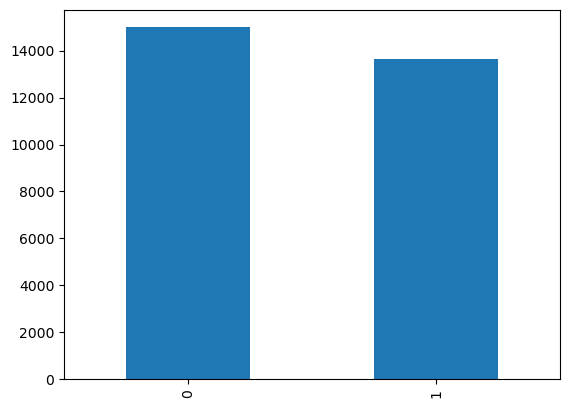

In [4]:
data = df["is_sarcastic"]
data.value_counts().plot.bar()
plt.show()

In [5]:
spacy_model = spacy.load("pl_core_news_sm")

In [6]:
# Stop words
stop_words = spacy_model.Defaults.stop_words.copy()
stop_words.remove("nie")
print(stop_words)

{'one', 'cokolwiek', 'taka', 'xiv', 'czy', 'pani', 'przeciez', 'bede', 'ze', 'te', 'niech', 'czasem', 'jedna', 'oni', 'mamy', 'sposob', 'dwie', 'możliwe', 'tym', 'gdyz', 'bowiem', 'poniewaz', 'gdziekolwiek', 'zadne', 'bez', 'czyli', 'jaki', 'on', 'ich', 'wtedy', 'tych', 'żeby', 'musi', 'będzie', 'dziś', 'żadne', 'takze', 'które', 'ten', 'u', 'moga', 'albo', 'bardziej', 'ktorej', 'gdy', 'bo', 'wiele', 'w', 'iż', 'xv', 'totez', 'ktorzy', 'gdyby', 'naszego', 'dokąd', 'ja', 'ponad', 'są', 'twoja', 'ci', 'ciebie', 'dlaczego', 'mi', 'mam', 'był', 'oto', 'vi', 'jak', 'sama', 'twoim', 'wielu', 'wami', 'aj', 'niż', 'was', 'tobie', 'zaden', 'wam', 'były', 'jakby', 'niego', 'podczas', 'że', 'wasz', 'twym', 'coś', 'no', 'az', 'jakaś', 'zostal', 'tobą', 'zapewne', 'we', 'znowu', 'nami', 'wy', 'dużo', 'juz', 'według', 'my', 'przedtem', 'nią', 'jakkolwiek', 'którzy', 'gdyż', 'moje', 'dzis', 'będę', 'wasze', 'być', 'bardzo', 'mają', 'twoi', 'jednakże', 'totobą', 'moja', 'jakoś', 'jakiż', 'miał', 'acz'

In [7]:
# Punctuation
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [8]:
# Tokenizer
def spacy_tokenizer(sentence):
    doc = spacy_model(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in doc ]

    # Removing stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [9]:
texts = df['headline_pl'].to_list()
tokenized_sentences = [spacy_tokenizer(text) for text in texts]

In [12]:
# Word2Vec
w2v_model = gensim.models.Word2Vec(sentences=tokenized_sentences, vector_size=100, window=6, min_count=1)

In [13]:
w2v_model.train(tokenized_sentences, epochs=10, total_examples=len(tokenized_sentences))

(2011977, 2077060)

In [14]:
print("The no of words :", len(w2v_model.wv))

The no of words : 32485


In [15]:
def tokens_to_vector(sentence):
    vector_size = w2v_model.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sentence:
        if w in w2v_model.wv:
            ctr += 1
            wv_res += w2v_model.wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [16]:
vectors = [tokens_to_vector(tokenized_sentence) for tokenized_sentence in tokenized_sentences]

In [17]:
X = np.array(vectors)
Y = df['is_sarcastic'].to_numpy()

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, train_size=0.5, random_state=42)

In [19]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

In [20]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [21]:
# Model parameters
training_number = 1
model_name = 'sarcasm_pl_word2vec_own'
training_name = model_name
figures_dir = f"../../documentation/models/{model_name}/figures"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)
batch_size = 32

In [22]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [28]:
history = model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), epochs=10, batch_size=batch_size, callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/10
712/716 [============================>.] - ETA: 0s - loss: 0.5970 - accuracy: 0.6745
Epoch 1: saving model to ../../training_checkpoints\sarcasm_pl_word2vec_own\sarcasm_pl_word2vec_own\cp-0001.ckpt
716/716 [==============================] - 2s 3ms/step - loss: 0.5967 - accuracy: 0.6749 - val_loss: 0.6022 - val_accuracy: 0.6684
Epoch 2/10
691/716 [===========================>..] - ETA: 0s - loss: 0.5947 - accuracy: 0.6763
Epoch 2: saving model to ../../training_checkpoints\sarcasm_pl_word2vec_own\sarcasm_pl_word2vec_own\cp-0002.ckpt
716/716 [==============================] - 2s 2ms/step - loss: 0.5941 - accuracy: 0.6777 - val_loss: 0.6016 - val_accuracy: 0.6691
Epoch 3/10
699/716 [============================>.] - ETA: 0s - loss: 0.5935 - accuracy: 0.6773
Epoch 3: saving model to ../../training_checkpoints\sarcasm_pl_word2vec_own\sarcasm_pl_word2vec_own\cp-0003.ckpt
716/716 [==============================] - 2s 2ms/step - loss: 0.5935 - accuracy: 0.6774 - val_loss: 0.6013 - v

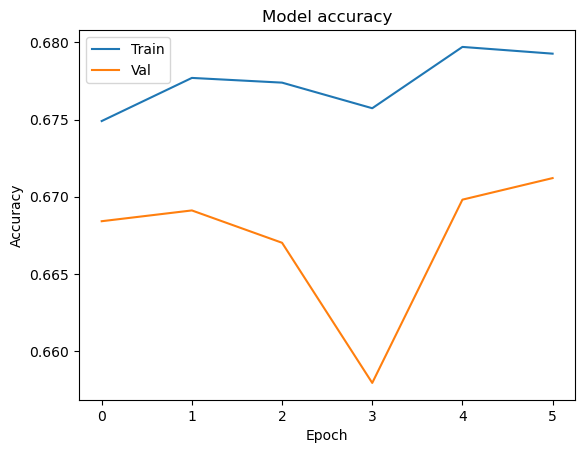

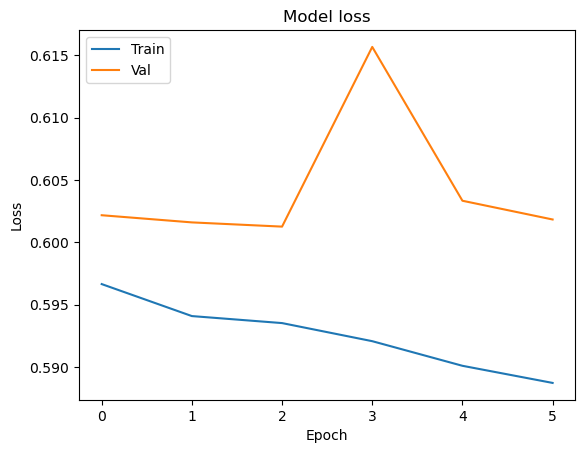

In [29]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [30]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

90/90 [==============================] - 0s 1ms/step


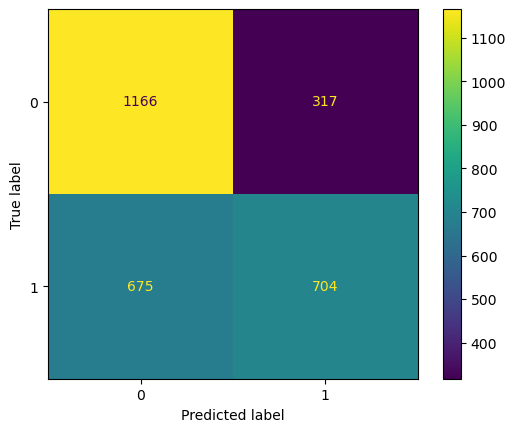

In [31]:
class_preds = model_utils.get_class_preds(best_model, X_test, model_returns_logits=False)
model_utils. plot_and_save_conf_matrix(class_actual=Y_test,
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [32]:
# Evaluation
best_model.evaluate(X_test, Y_test, batch_size=batch_size)

90/90 [==============================] - 0s 2ms/step - loss: 0.6033 - accuracy: 0.6534


[0.6032549142837524, 0.6533892154693604]

In [33]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number,
                       saved_models_dir=constants.SAVED_MODEL_LOCATION,
                       default_model_version=constants.DEFAULT_MODEL_VERSION)

INFO:tensorflow:Assets written to: ../../trained_models\sarcasm_pl_word2vec_own_1\1\assets
